This is a demonstration script for using the Altimetry object in the COAsT package. This object has strict data formatting requirements, which are outlined in altimetry.py.

### Relevant imports and filepath configuration

In [1]:
# Begin by importing coast and other packages
import coast

root = "../../"
# And by defining some file paths
dn_files = root + "./example_files/"
fn_nemo_dat = dn_files + "coast_example_nemo_data.nc"
fn_nemo_dom = dn_files + "coast_example_nemo_domain.nc"
fn_nemo_config = root + "./config/example_nemo_grid_t.json"
fn_altimetry = dn_files + "coast_example_altimetry_data.nc"
fn_altimetry_config = root + "./config/example_altimetry.json"

In [2]:
# We need to load in a NEMO object for doing NEMO things.
nemo = coast.Gridded(fn_nemo_dat, fn_nemo_dom, config=fn_nemo_config)

# And now we can load in our Altimetry data. By default, Altimetry is set up
# to read in CMEMS netCDF files. However, if no path is supplied, then the
# object's dataset will be initialised as None. Custom data can then be loaded
# if desired, as long as it follows the data formatting for Altimetry.
# altimetry = coast.Altimetry(fn_altimetry)
altimetry = coast.Altimetry(fn_altimetry, config=fn_altimetry_config)

../.././config/example_altimetry.json
Altimetry object at 0x10d73d528 initialised


### Subsetting

In [3]:
# Before going any further, lets just cut out the bit of the altimetry that
# is over the model domain. This can be done using `subset_indices_lonlat_box`
# to find relevant indices and then `isel` to extract them. The data here is then also
# also thinned slightly.
ind = altimetry.subset_indices_lonlat_box([-10, 10], [45, 60])
ind = ind[::4]
altimetry = altimetry.isel(t_dim=ind)

Subsetting Altimetry object at 0x10d73d528 indices in [-10, 10], [45, 60]


### Model interpolation

In [4]:
# Before comparing our observations to the model, we will interpolate a model
# variable to the same time and geographical space as the altimetry. This is
# done using the obs_operator() method:
altimetry.obs_operator(nemo, mod_var_name="ssh", time_interp="nearest")

# Doing this has created a new interpolated variable called interp_ssh and
# saved it back into our Altimetry object. Take a look at altimetry.dataset
# to see for yourself.

Interpolating Gridded object at 0x10d73d528 "ssh" with time_interp "nearest"


In [5]:
altimetry.dataset

<xarray.Dataset>
Dimensions:                   (t_dim: 54)
Coordinates:
  * time                      (t_dim) datetime64[ns] 2007-01-01T05:39:29.3490...
    longitude                 (t_dim) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    latitude                  (t_dim) float64 dask.array<chunksize=(19,), meta=np.ndarray>
Dimensions without coordinates: t_dim
Data variables:
    ocean_tide_standard_name  (t_dim) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    interp_ssh                (t_dim) float32 dask.array<chunksize=(54,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H17M35.44591S
    time_coverage_end:               2007-01-01T23:33:42Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2006-12-31T23:16:07Z
    title:                           DT Jason-1 Global Ocean Along track SSAL...

### Interpolated vs observed

In [6]:
# Next we will compare this interpolated variable to an observed variable
# using some basic metrics. The basic_stats() routine can be used for this,
# which calculates some simple metrics including differences, RMSE and
# correlations. NOTE: This may not be a wise choice of variables.
stats = altimetry.basic_stats("ocean_tide_standard_name", "interp_ssh")

Altimetry object at 0x10d73d528 initialised


In [7]:
# Take a look inside stats.dataset to see all of the new variables. When using
# basic stats, the returned object is also an Altimetry object, so all of the
# same methods can be applied. Alternatively, if you want to save the new
# metrics to the original altimetry object, set 'create_new_object = False'.

stats.dataset

<xarray.Dataset>
Dimensions:         (t_dim: 54)
Coordinates:
  * time            (t_dim) datetime64[ns] 2007-01-01T05:39:29.349092096 ... ...
    longitude       (t_dim) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    latitude        (t_dim) float64 dask.array<chunksize=(19,), meta=np.ndarray>
Dimensions without coordinates: t_dim
Data variables:
    absolute_error  (t_dim) float64 0.4755 0.5034 0.5171 ... 1.093 1.172 1.234
    error           (t_dim) float64 0.4755 0.5034 0.5171 ... -1.172 -1.234
    mae             float64 0.6499
    rmse            float64 0.7514
    corr            float64 0.7311
    cov             float64 246.1
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H17M35.44591S
    time_coverage_end:               2007-01-01T23:33:42Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2006-12-31T23:16:07Z
    title:                           DT Jason-1 Global Ocean Along track SSAL...

In [8]:
# Now we will do a more complex comparison using the Continuous Ranked
# Probability Score (CRPS). For this, we need to hand over the model object,
# a model variable and an observed variable. We also give it a neighbourhood
# radius in km (nh_radius).
crps = altimetry.crps(nemo, model_var_name="ssh", obs_var_name="ocean_tide_standard_name", nh_radius=20)

# Again, take a look inside `crps.dataset` to see some new variables. Similarly
# to basic_stats, `create_new_object` keyword arg can be set to `false` to save output to
# the original altimetry object.

crps.dataset

Altimetry object at 0x10d73d528 initialised


<xarray.Dataset>
Dimensions:             (t_dim: 54)
Coordinates:
    longitude           (t_dim) float64 dask.array<chunksize=(19,), meta=np.ndarray>
    latitude            (t_dim) float64 dask.array<chunksize=(19,), meta=np.ndarray>
  * time                (t_dim) datetime64[ns] 2007-01-01T05:39:29.349092096 ...
Dimensions without coordinates: t_dim
Data variables:
    crps                (t_dim) float64 0.4711 0.4922 0.5109 ... 1.147 1.216
    crps_n_model_pts    (t_dim) float64 24.0 23.0 27.0 24.0 ... 23.0 22.0 22.0
    crps_contains_land  (t_dim) bool False False False ... False False False
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H17M35.44591S
    time_coverage_end:               2007-01-01T23:33:42Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2006-12-31T23:16:07Z
    title:                           DT Jason-1 Global Ocean Along track SSAL...

### Plotting data

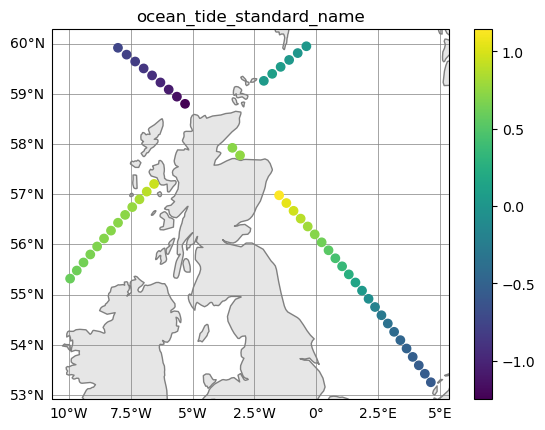

In [9]:
# Altimetry has a ready built quick_plot() routine for taking a look at any
# of the observed or derived quantities above. So to take a look at the
# 'sla_filtered' variable:
fig, ax = altimetry.quick_plot("ocean_tide_standard_name")

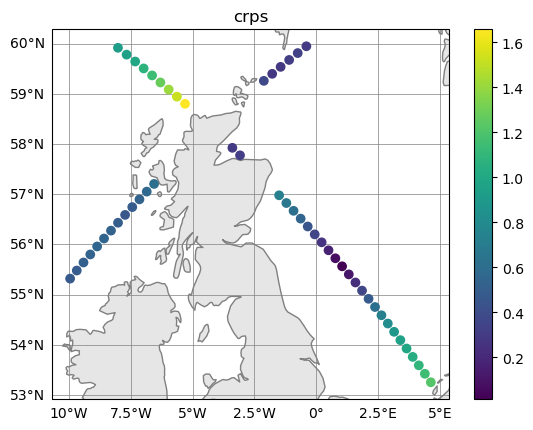

In [10]:
# As stats and crps are also Altimetry objects, quick_plot() can also be used:
# crps quick_plot:
fig, ax = crps.quick_plot("crps")

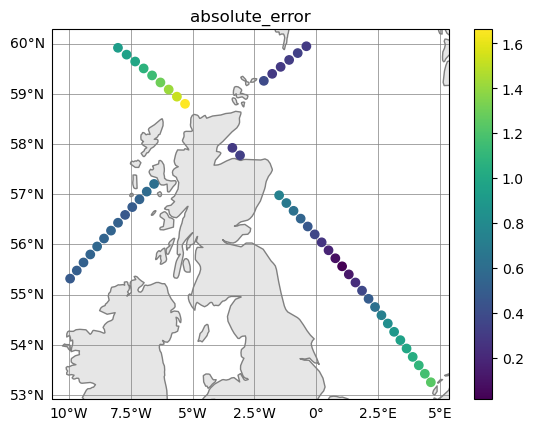

In [11]:
# stats quick_plot:
fig, ax = stats.quick_plot("absolute_error")